# Project 3 Recommender Systems

In [1]:
# 

In [2]:
import pandas as pd
import numpy as np
import random 

import matplotlib.pyplot as plt
import seaborn as sns

from surprise.model_selection.validation import cross_validate
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise import Reader, Dataset
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay

In [3]:
rand_seed = 42
np.random.seed(rand_seed)
random.seed(rand_seed)

In [4]:
folder_name = 'Synthetic_Movie_Lens/'
ratings_raw = pd.read_csv(folder_name+'ratings.csv', index_col=0)
movie = pd.read_csv(folder_name+'movies.csv')

In [5]:
ratings_raw.head(5)

,userId,movieId,rating,timestamp
0,496,112852,3.0,1415520462
1,391,1947,4.0,1030945141
2,387,1562,1.5,1095041022
3,474,2716,4.5,1053020930
4,483,88125,4.5,1311337237


In [6]:
movie.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings_mat_df = ratings_raw.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
ratings_mat_df

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.5,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0,0.0,4.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0


In [8]:
print(f'Number of users: {ratings_mat_df.shape[0]}')
print(f'Number of movies: {ratings_mat_df.shape[1]}')

Number of users: 610
Number of movies: 9724


### Question 1


#### Question 1.A

Computethe sparsity of the movie rating dataset:

Sparsity = Total number of available ratings / Total number of possible ratings


In [9]:
total_ratings = sum(ratings_mat_df.astype(bool).sum(axis=0))
total_possible_ratings = ratings_mat_df.shape[0]*ratings_mat_df.shape[1]
sparsity = total_ratings/total_possible_ratings

print(f'Total num of available ratings: {total_ratings}' )
print(f'Total num of possible ratings: {total_possible_ratings}' )
print(f'Sparsity: {sparsity}' )

Total num of available ratings: 100836
Total num of possible ratings: 5931640
Sparsity: 0.016999683055613623


#### Question 1.B

Plot a histogram showing the frequency of the rating values: Bin the raw rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R that fall within each bin and use this count as the height of the vertical axis for that particular bin. Comment on the shape of the histogram.

In [10]:
# Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).
sorted(ratings_raw.rating.unique())

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

Text(0, 0.5, 'Number of Ratings')

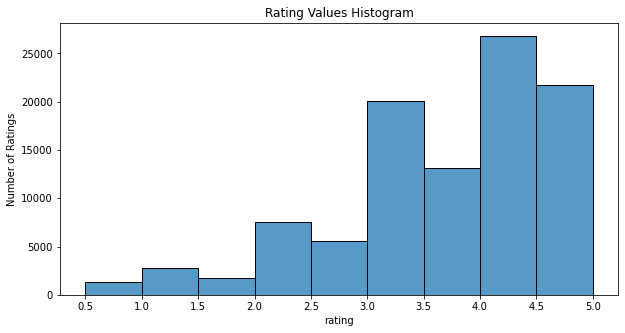

In [11]:
bins_range = sorted(ratings_raw.rating.unique())
plt.figure(figsize=(10,5))
g = sns.histplot(data=ratings_raw, x="rating", bins=bins_range)
#g.set(xticklabels=bins_range)
plt.xticks(bins_range)
plt.title('Rating Values Histogram')
plt.ylabel('Number of Ratings')

The ratings are within the 0.5 to 5.0 range. Users who gave ratings tends to give higher rating scores since the trend of the histogram is towards the higher ratings. Around 81% of the ratings are 3 and above and 21.5% is 4.5 and above. One possible interpretation is that users may tend to give ratings to the movies they like or they liked the movies they watched.


In [12]:
print(ratings_raw.rating.value_counts(sort=True))
print(ratings_raw.rating.value_counts(sort=True, normalize=True))

4.0    26816
3.0    20046
5.0    13211
3.5    13136
4.5     8553
2.0     7551
2.5     5551
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64
4.0    0.265937
3.0    0.198798
5.0    0.131015
3.5    0.130271
4.5    0.084821
2.0    0.074884
2.5    0.055050
1.0    0.027877
1.5    0.017762
0.5    0.013586
Name: rating, dtype: float64


#### Question 1.C

Plot the distribution of the number of ratings received among movies: The X-axis should be the movie index ordered by decreasing frequency and the Y -axis should be the number of ratings the movie has received; ties can broken in any way. A monotonically decreasing trend is expected.

In [13]:
rating_count_per_movie = pd.DataFrame(ratings_raw.groupby(by='movieId').rating.count().sort_values(ascending=False))
rating_count_per_movie.reset_index(inplace=True)
rating_count_per_movie

,movieId,rating
0,356,329
1,318,317
2,296,307
3,593,279
4,2571,278
...,...,...
9719,57502,1
9720,57522,1
9721,57526,1
9722,4032,1


Text(0, 0.5, 'Number of Ratings')

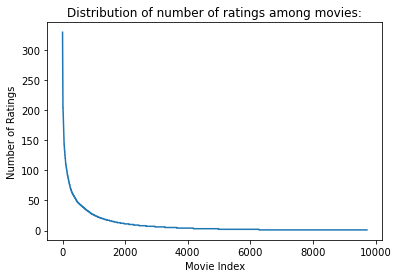

In [14]:
plt.plot(rating_count_per_movie.rating.values)
plt.title('Distribution of number of ratings among movies:')
plt.xlabel('Movie Index')
plt.ylabel('Number of Ratings')

In [15]:
rating_count_per_movie.describe().T

,count,mean,std,min,25%,50%,75%,max
movieId,9724.0,42245.024373,52191.137320,1.0,3245.5,7300.0,76739.25,193609.0
rating,9724.0,10.369807,22.401005,1.0,1.0,3.0,9.00,329.0


In [16]:
rating_count_per_movie.rating.value_counts(normalize=True)

1      0.354381
2      0.133484
3      0.082271
4      0.054504
5      0.039284
         ...   
203    0.000103
211    0.000103
251    0.000103
215    0.000103
307    0.000103
Name: rating, Length: 177, dtype: float64

As expected we observe a monotonically decreasing trend. Majority of the movies rated very few or 1 times.

#### Question 1.D

Plot the distribution of ratings among users: The X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user has rated. The requirement of the plot is similar to that in Question C.

In [17]:
rating_count_per_user = pd.DataFrame(ratings_raw.groupby(by='userId').rating.count().sort_values(ascending=False))
rating_count_per_user.reset_index(inplace=True)
rating_count_per_user

,userId,rating
0,414,2698
1,599,2478
2,474,2108
3,448,1864
4,274,1346
...,...,...
605,569,20
606,194,20
607,147,20
608,406,20


Text(0, 0.5, 'Number of Ratings')

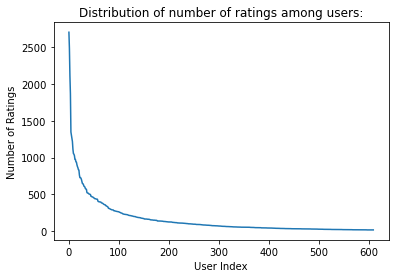

In [18]:
plt.plot(rating_count_per_user.rating.values)
plt.title('Distribution of number of ratings among users:')
plt.xlabel('User Index')
plt.ylabel('Number of Ratings')

In [19]:
rating_count_per_user.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,610.0,305.500000,176.236111,1.0,153.25,305.5,457.75,610.0
rating,610.0,165.304918,269.480584,20.0,35.00,70.5,168.00,2698.0


In [20]:
rating_count_per_user.rating.value_counts(normalize=True).sort_index()

20      0.022951
21      0.024590
22      0.022951
23      0.021311
24      0.011475
          ...   
1346    0.001639
1864    0.001639
2108    0.001639
2478    0.001639
2698    0.001639
Name: rating, Length: 261, dtype: float64

In [21]:
rating_count_per_user.rating.value_counts(normalize=True).sort_index().cumsum().head(51)

20    0.022951
21    0.047541
22    0.070492
23    0.091803
24    0.103279
25    0.118033
26    0.139344
27    0.152459
28    0.165574
29    0.178689
30    0.183607
31    0.195082
32    0.206557
33    0.222951
34    0.237705
35    0.255738
36    0.270492
37    0.280328
38    0.291803
39    0.298361
40    0.308197
41    0.314754
42    0.322951
43    0.327869
44    0.332787
45    0.342623
46    0.350820
47    0.357377
48    0.368852
50    0.380328
51    0.388525
52    0.391803
53    0.398361
54    0.403279
55    0.406557
56    0.429508
57    0.436066
58    0.444262
59    0.449180
60    0.452459
61    0.460656
62    0.463934
63    0.465574
64    0.473770
65    0.480328
66    0.483607
67    0.486885
68    0.488525
69    0.496721
70    0.500000
71    0.501639
Name: rating, dtype: float64

Again we see a decreasing trend with a tailed curve. There are some users who did a lot of ratings but majority seems to did low number of ratings. The minimum number of ratings among the users is 20. 

#### Question 1.E

Discuss the salient features of the distributions from Questions C,D and their implications for the recommendation process.

In 1.C, the number of ratings given to movies has a monotonically decreasing trend with a long tail on the right. This means majority of the movies get very low number of ratings where few of the movies get majority of the ratings. Around 35.4% movies get only 1 rating. Similarly, in 1.D, the number of ratings given by users has a monotonically decreasing trend with a long tail as well. This means majority of the users gave few ratings, and there are few users with very high number of ratings. Half of the users gave at least 20 and at most 70 movie ratings. Given that we have 610 users and 9724 movies, the ratings matrix R is a sparse matrix. The sparsity wee calculate in Q1.A with 0.0169 confirms this. Having a sparse matrix makes recommendation systems job harder, as there are few links between users and movies. Given the sparsity of matrix finding the similarities between users or movies will be challenging because we will have to work on small number of ratings, given that majority of the values are 0. 

TODO add regularization oage 6 descrip

#### Question 1.F

Compute the variance of the rating values received by each movie: Bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the resulting histogram.
 

In [22]:
rating_count_per_movie_var = pd.DataFrame(ratings_raw.groupby(by='movieId').agg(max_rating=('rating', 'max'), min_rating=('rating', 'min'), rating_variance=('rating', 'var'), rating_count=('rating', 'count'), rating_mean=('rating', 'mean'))).reset_index()
rating_count_per_movie_var.head(30).T


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
movieId,1.00000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000,10.000000,...,21.000000,22.000000,23.000,24.000000,25.0000,26.000,27.000000,28.000000,29.000000,30.0
max_rating,5.00000,5.000000,5.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000,5.000000,...,5.000000,5.000000,5.000,5.000000,5.0000,4.000,5.000000,5.000000,5.000000,4.0
min_rating,0.50000,0.500000,0.500000,1.000000,0.500000,1.000000,1.000000,1.000000,1.500,0.500000,...,1.000000,1.000000,1.000,1.000000,1.0000,2.500,2.000000,2.500000,2.000000,1.0
rating_variance,0.69699,0.777419,1.112651,0.726190,0.822917,0.670841,0.955625,1.267857,0.950,0.738535,...,0.752809,0.677778,1.250,1.030093,1.2475,0.375,1.437500,0.618182,0.682255,3.0
rating_count,215.00000,110.000000,52.000000,7.000000,49.000000,102.000000,54.000000,8.000000,16.000,132.000000,...,89.000000,36.000000,16.000,28.000000,76.0000,13.000,9.000000,11.000000,38.000000,3.0
rating_mean,3.92093,3.431818,3.259615,2.357143,3.071429,3.950980,3.185185,2.875000,3.125,3.496212,...,3.494382,3.222222,3.125,3.125000,3.6250,3.500,3.333333,4.227273,4.013158,3.0


In [23]:
rating_count_per_movie_var.describe()

,movieId,max_rating,min_rating,rating_variance,rating_count,rating_mean
count,9724.000000,9724.000000,9724.000000,6278.000000,9724.000000,9724.000000
mean,42245.024373,3.912999,2.416495,0.857169,10.369807,3.262448
std,52191.137320,1.056532,1.241600,0.795839,22.401005,0.869874
min,1.000000,0.500000,0.500000,0.000000,1.000000,0.500000
25%,3245.500000,3.500000,1.500000,0.395833,1.000000,2.800000
50%,7300.000000,4.000000,2.500000,0.702111,3.000000,3.416667
75%,76739.250000,5.000000,3.500000,1.105310,9.000000,3.911765
max,193609.000000,5.000000,5.000000,10.125000,329.000000,5.000000


[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]


Text(0.5, 1.0, 'Histogram of Rating Values Variance per movie')

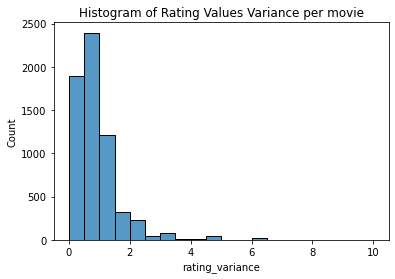

In [24]:
bin_vals = np.arange(rating_count_per_movie_var.rating_variance.min(), rating_count_per_movie_var.rating_variance.max(),0.5)
print(bin_vals)
sns.histplot(data=rating_count_per_movie_var, x="rating_variance", bins=bin_vals)
plt.title('Histogram of Rating Values Variance per movie')

In [25]:
rating_count_per_movie_var.rating_variance.value_counts()

0.500000    353
0.125000    345
0.000000    298
1.125000    182
2.000000    129
           ... 
0.773958      1
1.118577      1
1.725000      1
0.618182      1
1.055556      1
Name: rating_variance, Length: 2841, dtype: int64

I used unbiased estimator.

</color=red> TODO comment on the resulting shape
explained diff btw biased vs unbiased histogram

### Question 2

#### Question 2.A

Write down the formula for $μ_u$ in terms of $I_u$ and $r_{uk}$


 $$ \mu_u = \frac{\text{Sum of ratings given by user u}}{\text{Number of ratings given by user u}} $$
 
 
 $$  \mu_u = \frac{\sum_{k	\in I_u} r_{uk}}{|I_u|}    $$

#### Question 2.B

In plain words, explain the meaning of $I_u ∩ I_v$. Can $ I_u ∩ I_v = ∅$ ? (Hint: Rating matrix R is sparse)

$I_u ∩ I_v$ are the set of movies where both user u and user v rated. Because R matrix is sparse, it is very likely that for some user u and user v, they don't have any common movies they rated, hence the intersection of them is empty ($ I_u ∩ I_v = ∅$).

### Question 3

Understanding the Prediction function: Can you explain the reason behind mean-centering the raw ratings $(r_{vj} − μ_v)$ in the prediction function? (Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function.)

 Ratings can be subjective for every person, some people might be more prone to give higher scores and some prone to give lower scores. Therefore, score distribution of users also could be very different. We are not interested in the absolute rating for a movie from a user, because let's say an average rating for user A is 4 and he gave a movie rating 2.5 to movie X, thinks movie is bad, and user B has an average rating of 2. Then when we try to predict User B's rating, if we use absolute score, user B will think like user A liked the movie (user B's avg was 2) and become prone to like movie X. If both users have similar tastes, B should have dislike the movie as well. 

To reduce subjectivity and bias, we should interpret the score given by users relatively rather than absolute rating, and standardize them. Otherwise we might end up misinterpreting the score. To standardize user ratings we do mean centering around each user. In this way, mean centering can reduce the user bias, and help us predict more accurate and unbiased rating scores.

### Question 4

Design a k-NN collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).


In [26]:
reader = Reader(rating_scale=(0.5, 5))
ratings_data = Dataset.load_from_df(ratings_raw[['userId', 'movieId', 'rating']], reader)

In [27]:
def evaluate_model(data, k_range, plot_dets, is_plot=True, print_update=False):
    avg_rmse, avg_mae = [], []
    cv_results_list = []
    for i, k in enumerate(k_range):
        if i % 10==0 and print_update:
            print(f'{i} / {len(k_range)} -- k: {k}')
        model = KNNWithMeans(k=k, sim_options = {'name':'pearson', 'user_based':True}, verbose=0) 
        cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
        cv_results_list.append(cv_results)
        avg_rmse.append(np.mean(cv_results['test_rmse']))
        avg_mae.append(np.mean(cv_results['test_mae']))
        
    if is_plot: 
        plot_evaluation_metric(x= k_range, 
                               ys=[avg_rmse],
                               x_label=plot_dets['x_label'],
                               y_label='Average RMSE accross 10-fold CV',
                               title=plot_dets['title'], 
                               labels=['Average RMSE'])
        plot_evaluation_metric(x= k_range, 
                               ys=[avg_mae],
                               x_label=plot_dets['x_label'],
                               y_label='Avergae MAE accross 10-fold CV',
                               title=plot_dets['title'], 
                               labels=['Average MAE'])
        res_pdf = pd.DataFrame({'k': k_range, 'avg_rmse':avg_rmse, 'avg_mae':avg_mae, 'cv_results':cv_results_list })
        return res_pdf

def plot_evaluation_metric(x, ys, x_label, y_label, title, labels,  fig_size=(10,7)):
    colors = ['blue','green','orange','purple']
    plt.figure(figsize=fig_size)
    for i, y in enumerate(ys):
        plt.plot(x, y, label = labels[i], color=colors[i])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.show()

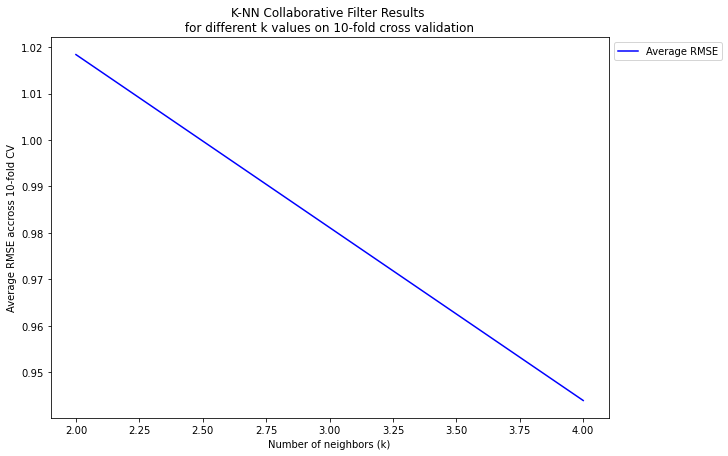

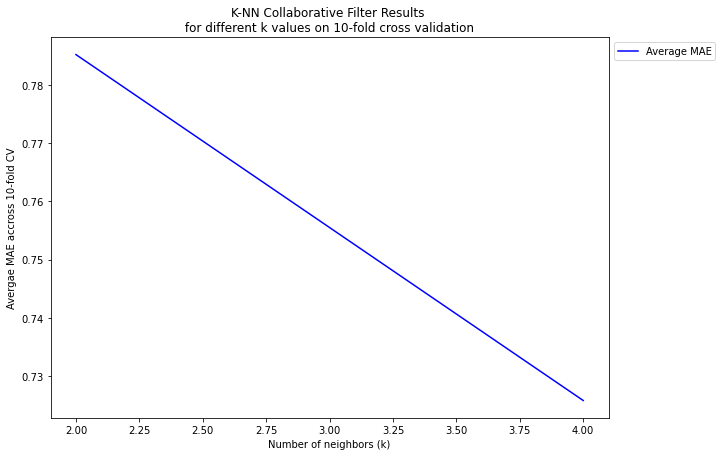

In [31]:
plot_dets_q4 = {
    'x_label': 'Number of neighbors (k)',
    'y_label': 'Average Test Error accross 10-fold CV',
    'title': 'K-NN Collaborative Filter Results \n for different k values on 10-fold cross validation '
}
k_range_q4 = list(range(2, 5, 2))   # to do change range to 100
q4_exp_df = evaluate_model(data=ratings_data, k_range=k_range_q4, plot_dets=plot_dets_q4)

In [33]:
q4_exp_df.head(3)

,k,avg_rmse,avg_mae,cv_results
0,2,1.018401,0.785199,"{'test_rmse': [1.0064455149967226, 1.031740256..."
1,4,0.943863,0.725791,"{'test_rmse': [0.9361455127443382, 0.936461550..."


### Question 5

Use the plot from question 4, to find a ’minimum k’. Note: The term ’minimum k’ in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE.

In [35]:
q4_exp_df[['k','avg_rmse','avg_mae']]

,k,avg_rmse,avg_mae
0,2,1.018401,0.785199
1,4,0.943863,0.725791


In [36]:
# TODO answer question

### Question 6

In [37]:
popular_movies = rating_count_per_movie_var[rating_count_per_movie_var.rating_count > 2].movieId.values
unpopular_movies = rating_count_per_movie_var[rating_count_per_movie_var.rating_count <= 2].movieId.values
high_var_movies = rating_count_per_movie_var[(rating_count_per_movie_var.rating_count >= 5) & (rating_count_per_movie_var.rating_variance >= 2)].movieId.values

print(f'Number of popular movies: {len(popular_movies)}')
print(f'Number of unpopular movies: {len(unpopular_movies)}')
print(f'Number of high variance movies: {len(high_var_movies)}')

Number of popular movies: 4980
Number of unpopular movies: 4744
Number of high variance movies: 87


In [41]:
def clean_based_on_trim_type(data, trim_type):
    trimmed_data = None
    if trim_type == 'popular':
        trimmed_data = trim_popular(data)
    elif trim_type == 'unpopular':
        trimmed_data = trim_unpopular(data)
    elif trim_type == 'high_variance':
        trimmed_data = trim_high_variance(data)
    else: 
        raise 'Wrong trim type: select from popular, unpopular or high_variance'
    return trimmed_data

def trim_popular(data):
    trimmed_data = [x for x in data if x[0] in popular_movies] 
    return trimmed_data

def trim_unpopular(data):
    trimmed_data = [x for x in data if x[0] in unpopular_movies] 
    return trimmed_data

def trim_high_variance(data):    
    trimmed_data = [x for x in data if x[0] in high_var_movies] 
    return trimmed_data

def get_model(model_type, k):
    model = None
    if model_type == 'knn':
        model = KNNWithMeans(k=k, sim_options = {'name':'pearson', 'user_based':True}, verbose=0) 
        
    else: 
        raise 'Wrong trim type: select from popular, unpopular or high_variance'
        
    return model

In [71]:
def evaluate_model_on_trimsets(data, model_type, k_range, plot_dets, trim_types, is_plot=True, print_update=False):
 
    kf = KFold(n_splits=10)
    all_rmses, all_maes, res_dfs = [],[], []
    for trim_type in trim_types:
        avg_rmse, avg_mae = [], []
        cv_results_dict = {}
        for i, k in enumerate(k_range):
            if i % 10==0 and print_update:
                    print(f'{i} / {len(k_range)} -- k: {k}')

            k_rmses, k_maes = [], []
            for train_data, test_data in kf.split(data):
                model = get_model(model_type=model_type, k=k)    #KNNWithMeans(k=k, sim_options = {'name':'pearson', 'user_based':True}, verbose=0) 
                model.fit(train_data)

                # clean test set based on trim type (popular, unpopular, high variance)
                if not trim_type:
                    test_data_trimmed=test_data
                else:
                    test_data_trimmed = clean_based_on_trim_type(data=test_data, trim_type=trim_type)
                preds = model.test(test_data_trimmed)

                k_rmses.append(accuracy.rmse(preds, verbose=False))
                k_maes.append(accuracy.mae(preds, verbose=False))

            cv_results_dict[k]={'rmse_results':k_rmses, 'mae_results':k_maes}    
            avg_rmse.append(np.mean(k_rmses))
            avg_mae.append(np.mean(k_maes))
        trim_type_name = trim_type if trim_type else 'original'
        res_df = pd.DataFrame({'k': k_range, f'avg_rmse_{trim_type_name}':avg_rmse, f'avg_mae_{trim_type_name}':avg_mae}) #, 'cv_results':[cv_results_dict]})
        res_dfs.append(res_df)
        all_rmses.append(avg_rmse)
        all_maes.append(avg_mae)
         
    if is_plot: 
        title = f'K-NN Collaborative Filter Results \n for different test set and k values \n on 10-fold cross validation '
        trim_names = []
        for trim_type in trim_types:
            trim_name=None
            if not trim_type:
                trim_name = 'Original'
            elif trim_type=='high_variance':
                trim_name = 'High Variance'
            else:
                trim_name = trim_type.capitalize()
            trim_names.append(trim_name)
        plot_evaluation_metric(x= k_range, 
                               ys=all_rmses,
                               x_label=plot_dets['x_label'],
                               y_label='Average RMSE',
                               title=f'K-NN Collaborative Filter Results \n Avergae RMSE on 10-fold cross validation \n for different test set and k values', 
                               labels=[f'Average RMSE - {x} test set' for x in trim_names])
        plot_evaluation_metric(x= k_range, 
                               ys=all_maes,
                               x_label=plot_dets['x_label'],
                               y_label='Avergae MAE',
                               title=f'K-NN Collaborative Filter Results \n Avergae MAE on 10-fold cross validation \n for different test set and k values', 
                               labels=[f'Average MAE - {x} test set' for x in trim_names])
       
    return res_dfs
    

In [39]:
def plot_roc(fprs, tprs, thresholds, aucs, axs=None, title=''):
    lw = 2
    colors = ['green', 'orange','pink','blue']
    
    if not axs:
        plt.figure(figsize=(12,12))
    for i in range(len(thresholds)):
        if not axs:
            plt.scatter(
                fprs[i],
                tprs[i],
                color=colors[i],
                lw=lw,
                label=f"THR {thresholds[i]}:  AUC: {aucs[i]:.3f})",
            )
        else:
            axs.scatter(
                fprs[i],
                tprs[i],
                color=colors[i],
                lw=lw,
                label=f"THR {thresholds[i]}:  AUC: {aucs[i]:.3f})",
            )
    if not axs:
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title("ROC Curve ")
        plt.legend(loc="lower right")
        plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
        plt.show()
    else:
        axs.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        axs.set_xlim([0.0, 1.0])
        axs.set_ylim([0.0, 1.05])
        axs.set(xlabel="False Positive Rate (FPR)", ylabel="True Positive Rate (TPR)")
        axs.set_title("ROC Curve "+title)
        axs.legend(loc="lower right")
    
def plot_roc_curves(data, model_type, trim_type, chosen_k, thresholds, axes=None):
    train_data, test_data = train_test_split(data, test_size=.1)

    model = get_model(model_type=model_type, k=chosen_k)
    model.fit(train_data)
    if not trim_type:
        test_data_trimmed= test_data
    else:
        test_data_trimmed = clean_based_on_trim_type(data=test_data, trim_type=trim_type)
    preds = model.test(test_data_trimmed)
    aucs, fprs, tprs = [], [], []
           
    for thr in thresholds:

        preds_vals = [pred.est for pred in preds]
        preds_vals_thresholded = [1 if pred.est > thr else 0 for pred in preds ]
        ground_truth_thresholded = [1 if pred.r_ui > thr else 0 for pred in preds ]

        fpr, tpr, ths = roc_curve(y_true=ground_truth_thresholded, y_score=preds_vals_thresholded)
        fprs.append(fpr)
        tprs.append(tpr)
        roc_auc_score = auc(fpr, tpr)
        aucs.append(roc_auc_score)

    trim_name=None
    if not trim_type:
        trim_name = 'Original'
    elif trim_type=='high_variance':
        trim_name = 'High Variance'
    else:
        trim_name = trim_type.capitalize() 
    plot_roc(fprs=fprs, tprs=tprs, thresholds=thresholds, aucs=aucs, axs=axes, title=f'for {model_type.upper()} on {trim_name} test set')


def multiple_rocs(data, model_type, trim_types,  chosen_k, thresholds, suptitle=''):
    fig, axs = plt.subplots(2, 2, figsize=(12,12))
    indices = [(0,0), (0,1),(1,0), (1,1)]
    for idx, (i,j) in  enumerate(indices):
        plot_roc_curves(data, model_type, trim_types[idx], chosen_k, thresholds, axes=axs[i,j])
    plt.suptitle(suptitle)
    plt.show()

##### Results on Original Test set and Popular, Unpopular, High Variance Trimmed Test Sets

0 / 3 -- k: 2
0 / 3 -- k: 2
0 / 3 -- k: 2
0 / 3 -- k: 2


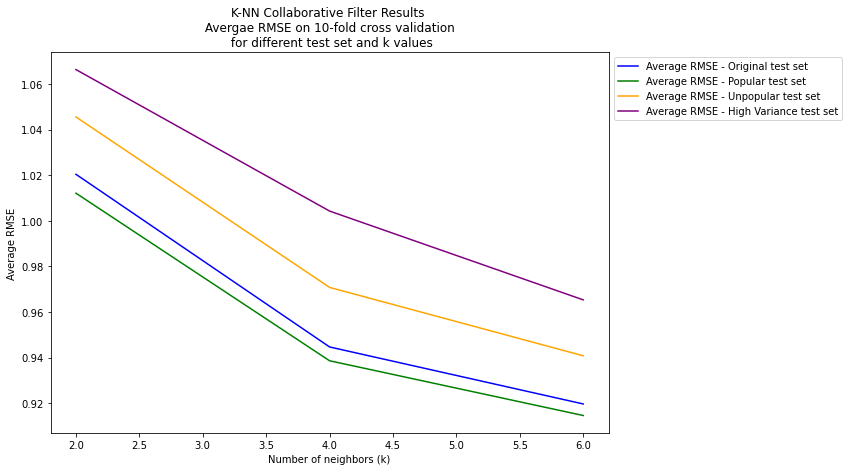

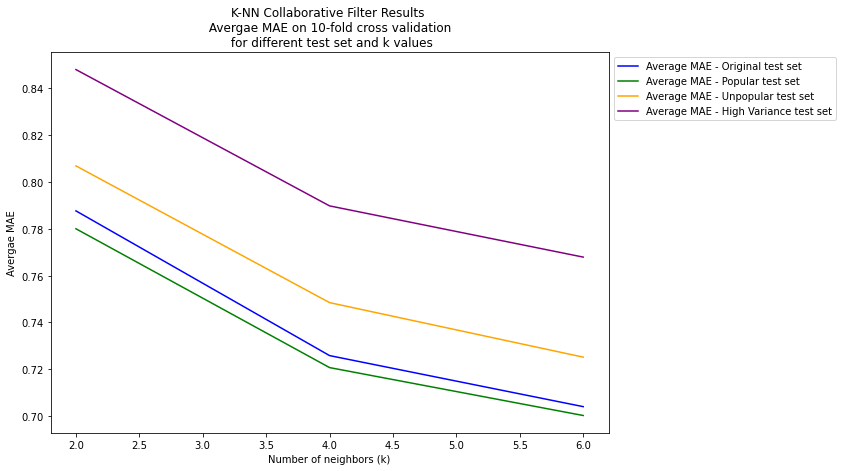

In [72]:
plot_dets_q6 = {
    'x_label': 'Number of neighbors (k)',
    'y_label': 'Average Test Error accross 10-fold CV'
}
k_range_q6 = list(range(2, 7, 2))  # to do change range to 100
q6_knn_res_dfs = evaluate_model_on_trimsets(data=ratings_data,
                                                   model_type='knn',
                                                   k_range=k_range_q6, 
                                                   plot_dets=plot_dets_q6, 
                                                   trim_types = [None, 'popular','unpopular','high_variance'],
                                                   is_plot=True, 
                                                   print_update=True) #TODO make it false later

In [70]:
q6_knn_res_df = pd.concat(q6_knn_res_dfs)
q6_knn_res_df_pivot = q6_knn_res_df.pivot_table(columns='k').T
display(q6_knn_res_df_pivot.head(10))
display(q6_knn_res_df_pivot.describe())
print('Min Avg RMSE and Avg MAE for each test set:')
print(q6_knn_res_df_pivot.min())

,avg_mae_high_variance,avg_mae_original,avg_mae_popular,avg_mae_unpopular,avg_rmse_high_variance,avg_rmse_original,avg_rmse_popular,avg_rmse_unpopular
k,,,,,,,,
2,0.868735,0.784176,0.781019,0.808709,1.095345,1.016071,1.012169,1.048724
4,0.798695,0.727495,0.722298,0.746608,1.006261,0.947032,0.940057,0.965965
6,0.772542,0.704407,0.700704,0.723106,0.979831,0.919091,0.914202,0.943851


,avg_mae_high_variance,avg_mae_original,avg_mae_popular,avg_mae_unpopular,avg_rmse_high_variance,avg_rmse_original,avg_rmse_popular,avg_rmse_unpopular
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.813324,0.738693,0.734674,0.759474,1.027146,0.960731,0.955476,0.986180
std,0.049737,0.041046,0.041564,0.044228,0.060523,0.049920,0.050771,0.055282
min,0.772542,0.704407,0.700704,0.723106,0.979831,0.919091,0.914202,0.943851
25%,0.785618,0.715951,0.711501,0.734857,0.993046,0.933061,0.927129,0.954908
50%,0.798695,0.727495,0.722298,0.746608,1.006261,0.947032,0.940057,0.965965
75%,0.833715,0.755835,0.751659,0.777658,1.050803,0.981551,0.976113,1.007345
max,0.868735,0.784176,0.781019,0.808709,1.095345,1.016071,1.012169,1.048724


Min Avg RMSE and Avg MAE for each test set:
avg_mae_high_variance     0.772542
avg_mae_original          0.704407
avg_mae_popular           0.700704
avg_mae_unpopular         0.723106
avg_rmse_high_variance    0.979831
avg_rmse_original         0.919091
avg_rmse_popular          0.914202
avg_rmse_unpopular        0.943851
dtype: float64


#### ROC Curves for each test set

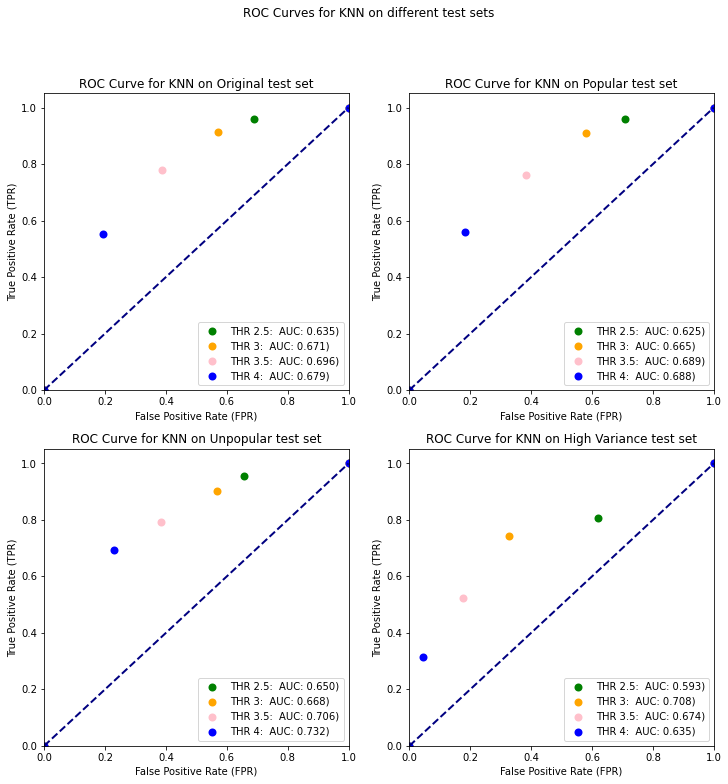

In [44]:
thresholds = [2.5, 3, 3.5, 4]
chosen_k = 20  # to do correct this later

multiple_rocs(data=ratings_data,
              model_type='knn', 
              trim_types = [None, 'popular','unpopular','high_variance'],
              chosen_k=chosen_k, 
              thresholds=thresholds,
              suptitle='ROC Curves for KNN on different test sets')

TODO report AUCS

In [ ]:
# TODO generalize the above functions for each model type
# TODO check if ROC curve correctly created?

## Model-based Collaborative Filtering

### Question 7

### Question 8

### Question 9

### Question 10

### Question 11

### Question 12

### Question 13

### Question 14